In [ ]:
!pip install pycrs
!pip install geemap
!pip install geopandas
!pip install colorbrewer


In [ ]:
from IPython.display import Image
import folium
from google.colab import drive
import os
import ee
import geemap as geemap
import matplotlib.pyplot as plt
import colorbrewer




drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/shapefile_union')
shapefile_path = 'shapefile_union.shp'

Mounted at /content/drive


In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize()

In [ ]:
# Carregar uma imagem Landsat
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

from IPython.display import Image
image.getThumbUrl({'bands': 'B4,B3,B2', 'min': 0, 'max': 0.3, 'dimensions': 512})

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2afdeef844b2c2af3bb59da11163bf2c-f1aa9424410aa88b5760eded7caa8c7f:getPixels'

In [ ]:
import geemap as geemap
shapefile_path = 'shapefile_union.shp'
aoi = geemap.shp_to_ee(shapefile_path, crs='EPSG:4326')
#aoi = geemap.shp_to_ee(shapefile_path)

image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
    .filterBounds(aoi)

mapa = geemap.Map()

# Adicionar a camada de imagens ao mapa
mapa.addLayer(image_collection, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Imagens Landsat')

mapa.addLayer(aoi, {'color': 'green'}, 'Área de Interesse')

centroid = aoi.geometry().centroid(1)
lon, lat = centroid.getInfo()['coordinates']
location = lat, lon

mapa.center = location
mapa.zoom = 12

# Exibir o mapa
display(mapa)


Map(center=[-7.169141806456969, -34.869221205473224], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:

# Carregar o shapefile
shapefile_path = 'shapefile_union.shp'
aoi = geemap.shp_to_ee(shapefile_path, crs='EPSG:4326')

# Definir os anos de interesse
anos = list(range(2013, 2018))

# Criar o mapa interativo com o geemap
mapa = geemap.Map()

for ano in anos:
    # Filtrar imagens Landsat usando a área de interesse e o ano
    image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA') \
        .filterBounds(aoi) \
        .filterDate(f'{ano}-01-01', f'{ano}-12-31') \
        .sort('CLOUD_COVER')

    # Verificar se a coleção de imagens é vazia
    if image_collection.size().getInfo() > 0:

        image = image_collection.first()

        image = image.clip(aoi)

        # Calcular o NDVI
        ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')

        # Adicionar a camada NDVI ao mapa
        mapa.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDVI {ano}')
    else:
        print(f'Nenhuma imagem disponível para o ano {ano}')

# Adicionar a área de interesse (shapefile) ao mapa
# mapa.addLayer(aoi, {'color': 'red'}, 'Área de Interesse')

# Obter o centroide da área de interesse
centroid = aoi.geometry().centroid(1)
lon, lat = centroid.getInfo()['coordinates']
location = lat, lon

# Ajustar o mapa para o centro da área de interesse
mapa.center = location
mapa.zoom = 12

# Exibir o mapa
display(mapa)



Map(center=[-7.169141806456969, -34.869221205473224], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
aoi = geemap.shp_to_ee(shapefile_path, crs='EPSG:4326')

start_year = 1985
end_year = 2012

anos = list(range(start_year, end_year + 1))

mapa = geemap.Map(basemap='SATELLITE')

ndvi_images = {}

# Coleção de imagens de diferentes Satélites
sentinel_2_harmonized = 'COPERNICUS/S2_HARMONIZED' # Banda 4 e 8
sentinel_2 = 'COPERNICUS/S2'          # Banda 4 e 8
sentinel_2A = "COPERNICUS/S2_SR"      # Banda 4 e 8
landsat_8 = 'LANDSAT/LC08/C01/T1_TOA' # Banda 4 e 5
landsat_5 = 'LANDSAT/LT05/C01/T1_TOA' # Banda 3 e 4
landsat_7 = 'LANDSAT/LE07/C02/T1_TOA' # Banda 3 e 4


for ano in anos:
    # Filtrar imagens Landsat usando a área de interesse e o ano
    image_collection = ee.ImageCollection(landsat_5) \
    .filterBounds(aoi) \
    .filterDate(f'{ano}-01-01', f'{ano}-12-31') \
    .sort('CLOUD_COVER')
    #.filter(ee.Filter.lt('CLOUD_COVER', 30))
    #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    #.filter(ee.Filter.lt('QA60', 1))
    #.sort('CLOUD_COVER')


    print(f'Número de imagens disponíveis para {ano}: {image_collection.size().getInfo()}')


    if image_collection.size().getInfo() > 0:

        # Recortar a imagem para a área de interesse
        clipped_images = image_collection.map(lambda image: image.clip(aoi))

        # Calcular a média das imagens da coleção
        image = clipped_images.mean()

        #image = image.clip(aoi)

        red = image.select('B3')
        nir = image.select('B4')

        # Calcular o NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

        ndvi = ndvi.set('system:time_start', ee.Date(f'{ano}-01-01').millis())


        # Armazenar a imagem NDVI no dicionário
        ndvi_images[ano] = ndvi

        # Adicionar a camada NDVI ao mapa
        mapa.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'NDVI {ano}')
    else:
        print(f'Nenhuma imagem disponível para o ano {ano}')

# Calcular a diferença de NDVI entre end_year e start_year
if end_year in ndvi_images and start_year in ndvi_images:
    diff = ndvi_images[end_year].subtract(ndvi_images[start_year])
    mapa.addLayer(diff, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'Diferença NDVI {end_year}-{start_year}')

# Adicionar a área de interesse (shapefile) ao mapa
# mapa.addLayer(aoi, {'color': 'red'}, 'Área de Interesse')


# Definir título do mapa
mapa.set_plot_options(title='Análise do NDVI')


# Obter o centroide da área de interesse
centroid = aoi.geometry().centroid(1)
lon, lat = centroid.getInfo()['coordinates']
location = lat, lon

# Ajustar o mapa para o centro da área de interesse
mapa.center = location
mapa.zoom = 12



# Exibir o mapa
display(mapa)


Número de imagens disponíveis para 1985: 3
Número de imagens disponíveis para 1986: 4
Número de imagens disponíveis para 1987: 4
Número de imagens disponíveis para 1988: 4
Número de imagens disponíveis para 1989: 7
Número de imagens disponíveis para 1990: 7
Número de imagens disponíveis para 1991: 8
Número de imagens disponíveis para 1992: 10
Número de imagens disponíveis para 1993: 12
Número de imagens disponíveis para 1994: 4
Número de imagens disponíveis para 1995: 3
Número de imagens disponíveis para 1996: 15
Número de imagens disponíveis para 1997: 6
Número de imagens disponíveis para 1998: 6
Número de imagens disponíveis para 1999: 14
Número de imagens disponíveis para 2000: 6
Número de imagens disponíveis para 2001: 16
Número de imagens disponíveis para 2002: 2
Número de imagens disponíveis para 2003: 11
Número de imagens disponíveis para 2004: 17
Número de imagens disponíveis para 2005: 15
Número de imagens disponíveis para 2006: 15
Número de imagens disponíveis para 2007: 15
N

Map(center=[-7.169141806456969, -34.869221205473224], controls=(WidgetControl(options=['position', 'transparen…

[176.10525563133115, 148.48541204145664, 108.60749495930304, 34.16259506294041, 138.8752409897178, 129.3174868442376, 88.95221675451988, 125.46010959305083, 107.78953942350583, 139.8222610323498, 112.56229903938379, 103.3814647917608, 124.64803649248127, 125.18220667917751, 74.02282762840036, 17.80243951579088, 85.25973867271503, 65.18566521745134, 107.31821525571524, 71.54683130103592, 64.16651438254, 117.66364614166275, 107.8697724121907, 125.2717269715834, None, 104.45063848648897, 75.39903132416795, None]


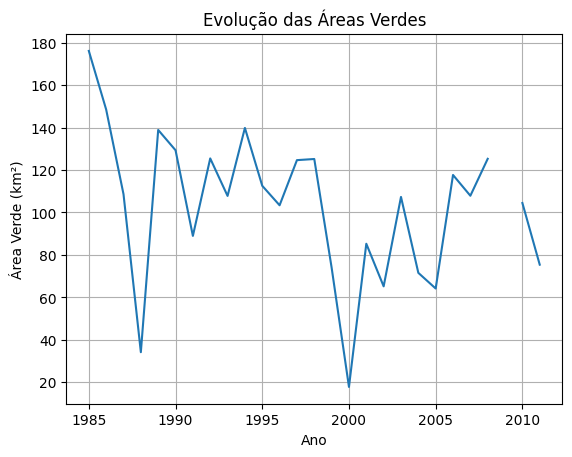

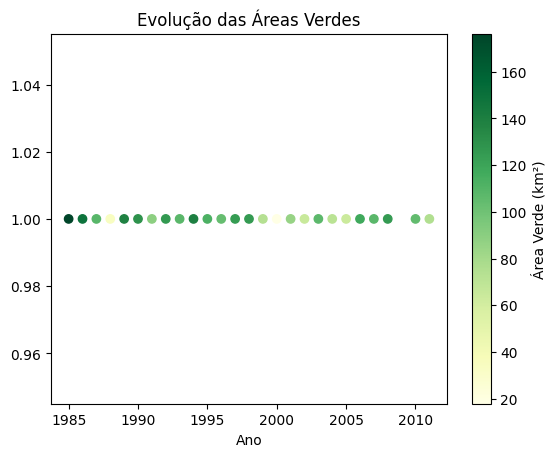

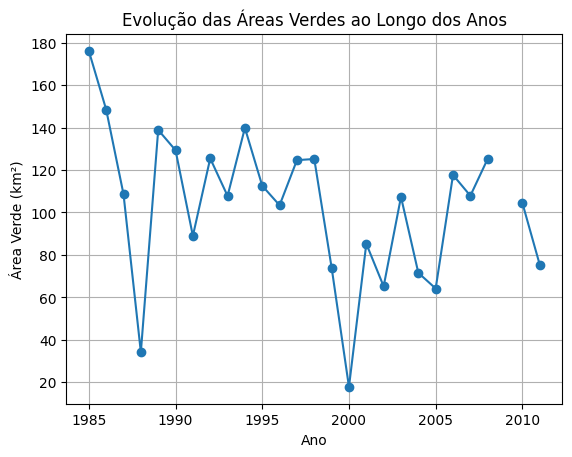

In [ ]:
green_areas = []
ndvi_threshold = 0.2
m2_to_km2 = 1e-6  # Fator de conversão de m² para km²

anos = list(range(start_year, end_year+1))

for ano in anos:
    if ano in ndvi_images:
        # Filtrar apenas os pixels com área verde
        green_mask = ndvi_images[ano].gt(ndvi_threshold)

        # Multiplicar a máscara binária pela área de cada pixel
        green_area = green_mask.multiply(image.pixelArea())

        # Calcular a soma da área verde em toda a imagem
        total_green_area = green_area.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=aoi.geometry(),
            scale=30,
            maxPixels=1e9
        )


        # Verificar se há uma área verde correspondente
        if 'NDVI' in total_green_area.getInfo():
            # Obter o valor da área total em metros quadrados
            area_in_square_meters = total_green_area.get('NDVI').getInfo()

            # Converter a área de metros quadrados para quilômetros quadrados
            area_in_square_km = area_in_square_meters * m2_to_km2

            green_areas.append(area_in_square_km)
        else:
            green_areas.append(None)
    else:
        green_areas.append(None)


print(green_areas)
# Plotar o gráfico
plt.plot(anos, green_areas)
plt.xlabel('Ano')
plt.ylabel('Área Verde (km²)')
plt.title('Evolução das Áreas Verdes')
plt.grid(True)
plt.show()


# Plotar o gráfico de cores
plt.scatter(anos, [1] * len(anos), c=green_areas, cmap='YlGn')
plt.colorbar(label='Área Verde (km²)')
plt.xlabel('Ano')
plt.title('Evolução das Áreas Verdes')
plt.show()


# Plotar o gráfico de séries temporais
plt.plot(anos, green_areas, marker='o')
plt.xlabel('Ano')
plt.ylabel('Área Verde (km²)')
plt.title('Evolução das Áreas Verdes ao Longo dos Anos')
plt.grid(True)

#for x, y in zip(anos, green_areas):
    #plt.text(x, round(y), str(y), ha='center', va='bottom')

plt.show()



In [ ]:
# Baixar imagens
for ano, ndvi in ndvi_images.items():
    task = ee.batch.Export.image.toDrive(
        image=ndvi,
        description=f'NDVI_{ano}',
        folder='NDVI_SENTINEL2_20_CLOUDY',
        fileNamePrefix=f'NDVI_{ano}',
        scale=30,
        region=aoi.geometry(),
        fileFormat='GeoTIFF',
        formatOptions={
            'cloudOptimized': True
        }
    )
    task.start()


In [ ]:

# CÁLCULO DE DIFERENÇA PERCENTUAL ENTRE DOIS ANOS


print(f'{start_year} in ndvi_images: {start_year in ndvi_images}')
print(f'{end_year} in ndvi_images: {end_year in ndvi_images}')
# Calcular a mudança percentual no NDVI entre start_year e end_year
if (start_year in ndvi_images) and (end_year in ndvi_images):
    diff = ndvi_images[end_year].subtract(ndvi_images[start_year])
    percent_change = diff.divide(ndvi_images[start_year]).multiply(100)
    mapa.addLayer(percent_change, {'min': -100, 'max': 100, 'palette': ['blue', 'white', 'green']}, f'Mudança Percentual NDVI {end_year}-{start_year}')

# Calcular a média da mudança percentual em toda a área de interesse
    mean_percent_change = percent_change.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e9
)

# Imprimir a média da mudança percentual
    print(mean_percent_change.getInfo())

display(mapa)


2014 in ndvi_images: True
2023 in ndvi_images: False


Map(bottom=545524.0, center=[-7.169141806456969, -34.869221205473224], controls=(WidgetControl(options=['posit…

In [ ]:
# APLICAÇÃO DE LIMIAR PARA ÁREAS VERDES + CÁLCULO DE ÁREA

limiar = 0.2

# Máscara binária
green_mask = ndvi.gt(limiar)

areas_verdes = ndvi.gte(limiar)


# Multiplica a máscara binária pela área de cada pixel
green_area = green_mask.multiply(image.pixelArea())

total_green_area = green_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e9
)

# Obtém o valor da área total em metros quadrados
area_in_square_meters = total_green_area.get('NDVI')

# Converte a área de metros quadrados para quilômetros quadrados
area_in_square_kilometers = ee.Number(area_in_square_meters).divide(1000000)

# Imprime o valor da área total em quilômetros quadrados
print('Área total de áreas verdes: {} km²'.format(area_in_square_kilometers.getInfo()))





# Adicionar camada das áreas verdes ao mapa
# mapa.addLayer(areas_verdes, {'palette': '00FF00'}, 'Áreas Verdes')

#display(mapa)

Área total de áreas verdes: 171.20132198635196 km²


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir os valores de classificação do NDVI
ndvi_thresholds = np.array([-1, 0.2, 0.5, 1], dtype=np.float32)

for ano, ndvi in ndvi_images.items():
    # Obter o valor do NDVI como um array NumPy
    ndvi_value = np.array(ndvi.getInfo()['NDVI'], dtype=np.float32)

    # Converter o array NDVI em uma matriz bidimensional
    ndvi_array = np.reshape(ndvi_value, (ndvi.shape[0], ndvi.shape[1]))

    # Classificar a imagem NDVI
    classified_image = np.digitize(ndvi_array, ndvi_thresholds)

    # Definir a paleta de cores
    palette = ['blue', 'green', 'gray']

    # Aplicar a paleta de cores à imagem classificada
    colored_image = np.zeros((classified_image.shape[0], classified_image.shape[1], 3), dtype=np.uint8)
    for i in range(3):
        colored_image[classified_image == (i + 1)] = matplotlib.colors.to_rgb(palette[i])

    # Plotar a imagem classificada
    plt.figure(figsize=(10, 10))
    plt.imshow(colored_image)
    plt.title(f'Classificação da Área - {ano}')
    plt.axis('off')
    plt.show()


KeyError: ignored

In [ ]:
# Baixar imagens

for ano, ndvi in ndvi_images.items():
    task = ee.batch.Export.image.toDrive(
        image=ndvi,
        description=f'NDVI_{ano}',
        folder='NDVI_images_FINAL',
        fileNamePrefix=f'NDVI_{ano}',
        scale=30,
        region=aoi.geometry(),
        fileFormat='GeoTIFF',
        formatOptions={
            'cloudOptimized': True
        }
    )
    task.start()

In [ ]:
# NAO RODAR


# Exportar a camada de NDVI como imagem
geemap.ee_export_image(ndvi, 'NDVI_image_2016-2023-LIMIAR0.2-CLOUDY20', scale=30, region=aoi.geometry(), file_per_band=False)

# Exportar a camada de mudança percentual como imagem
geemap.ee_export_image(percent_change, 'PercentChange_image', scale=30, region=aoi.geometry(), file_per_band=False)


The filename must end with .tif


NameError: ignored

In [ ]:
# Escolher os anos para calcular a diferença percentual
year1 = 2020
year2 = 2021

if (year1 in ndvi_images) and (year2 in ndvi_images):
    diff = ndvi_images[year2].subtract(ndvi_images[year1])
    percent_change = diff.divide(ndvi_images[year1]).multiply(100)

    # Adicionar a camada de diferença percentual ao mapa
    mapa.addLayer(percent_change, {'min': -100, 'max': 100, 'palette': ['blue', 'white', 'green']}, f'Mudança Percentual NDVI {year2}-{year1}')

    percent_change_value = percent_change.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi.geometry(),
    scale=30,
    maxPixels=1e9
    )
    print(f'Diferença Percentual entre {year1} e {year2}: {percent_change_value.get("NDVI").getInfo()}')


mapa

Map(bottom=545524.0, center=[-7.169141806456969, -34.869221205473224], controls=(WidgetControl(options=['posit…